In [1]:
import pandas as pd
import numpy as np

In [2]:
from dist import compute_AE_tanimoto_distance, compute_augmented_graph_distance
from dist import compute_embed3d_distance, hop_matrix_from_mol

## 1. Building High-Dimensional Probabilities (Weighted Graph)

In [27]:
from rdkit import Chem
smiles = "CNC(=O)c1cc(ccn1)Oc2ccc(cc2)NC(=O)Nc3ccc(c(c3)C(F)(F)F)Cl"
mol = Chem.MolFromSmiles(smiles)

In [28]:
D1 = compute_augmented_graph_distance(
    mol=mol,
    alpha=0.5,
    beta=0.5)
D2 = compute_AE_tanimoto_distance(
    mol=mol,
    radius=2, nBits=2048)

D3 = compute_embed3d_distance(
    mol=mol,)

hop = hop_matrix_from_mol(mol)

[15:09:06] Molecule does not have explicit Hs. Consider calling AddHs()
[15:09:06] Molecule does not have explicit Hs. Consider calling AddHs()


In [29]:
dist = D2
# hop = hop  # 这行没意义，删掉

K_HOP_MAX = 2
n = dist.shape[0]

# 每个节点的目标近邻数：deg+2，夹在[3,8]
try:
    deg = np.array([a.GetDegree() for a in mol.GetAtoms()], dtype=int)
    k_i = np.clip(deg + 2, 3, 8).astype(float)
except:
    k_i = np.full(n, 6.0, dtype=float)

def sigma_binary_search_row(k_of_sigma, fixed_k, lo=1e-6, hi=1.0, iters=32):
    while k_of_sigma(hi) < fixed_k:
        hi *= 2.0
        if hi > 1e6:
            break
    for _ in range(iters):
        mid = 0.5 * (lo + hi)
        if k_of_sigma(mid) < fixed_k:
            lo = mid
        else:
            hi = mid
    return 0.5 * (lo + hi)

def prob_row_from_sigma(sigma, d_row, rho_i):
    x = d_row - rho_i
    x[x < 0] = 0.0
    return np.exp(- x / (sigma + 1e-12))

def k_from_prob(prob_row):
    # smooth-k: sum(p) = log2(k+1)  =>  k(p) = 2^{sum p} - 1
    return np.power(2.0, float(prob_row.sum())) - 1.0

prob = np.zeros((n, n), dtype=float)
sigma_array = np.zeros(n, dtype=float)

for i in range(n):
    # 候选集合：hop≤K 且 非自身 且 距离有限
    cand = np.where((hop[i] <= K_HOP_MAX) & (np.arange(n) != i) & np.isfinite(dist[i]))[0]
    if cand.size == 0:
        sigma_array[i] = 0.0
        continue
    # 只有极少候选时，直接等权
    if cand.size <= 2:
        prob[i, cand] = 1.0 / cand.size
        sigma_array[i] = 0.0
        continue

    d_i = dist[i, cand].astype(float)

    # 该行 rho_i：候选里的最小正距离
    pos = d_i[d_i > 0]
    rho_i = float(pos.min()) if pos.size > 0 else 0.0

    # 目标 k：不超过候选数
    k_target = float(min(k_i[i], cand.size))

    def k_of_sigma(sig):
        p = prob_row_from_sigma(sig, d_i, rho_i)
        return k_from_prob(p)

    sigma_i = sigma_binary_search_row(k_of_sigma, k_target, lo=1e-6, hi=1.0, iters=32)
    sigma_array[i] = sigma_i

    # 注意：不要再做行归一化，保持 smooth-k 的总量
    p_row = prob_row_from_sigma(sigma_i, d_i, rho_i)
    prob[i, cand] = p_row

    if (i + 1) % 100 == 0 or i == n - 1:
        print(f"Sigma search row {i+1}/{n}")

print("Mean sigma =", float(sigma_array.mean()))

### The symmetric matrix of high-dimensional probabilities
# 对称化（UMAP 的 fuzzy union）
P = prob + prob.T - prob * prob.T


Sigma search row 32/32
Mean sigma = 0.11043912693979008


In [30]:
P

array([[0.        , 0.70728561, 0.65661369, ..., 0.        , 0.        ,
        0.        ],
       [0.70728561, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.65661369, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 2. Building Low-Dimensional Probabilities (Weighted Graph)

In [31]:
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances

model = SpectralEmbedding(n_components = 3, n_neighbors = 3, 
                          affinity = 'precomputed') #]

## 非监督的时候直接使用原子距离矩阵
dist_low = dist

#dist = squareform(mp.info_distance)
affinity_matrix  = np.exp(-(dist_low ** 2))

# Y就是原子初始化坐标 
Y = model.fit_transform(affinity_matrix) #
Y /= Y.max()

In [32]:
from scipy.optimize import curve_fit

In [33]:
MIN_DIST = 0.5

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 0.5830300205483709 and b = 1.334166992455648


In [34]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities v_ij in low-dimensional space
    """    
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances

In [35]:
def CE(P, Q):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact=np.expand_dims(a*P*(1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

Launch the Gradient Descent procedure:



In [36]:
lr = 1
epochs = 200

In [37]:
import matplotlib.pyplot as plt
from vis import visualize_molecule_with_coords
from vis import visualize_and_save_frame
import os
from render import render_html_to_image


In [38]:
# from render import render_html_to_image
# html_path = '1.html'
# output_path = 'rendered_output.png'

# render_html_to_image(html_path, output_path)


Cross-Entropy = 0.0091 after 0 iterations
Cross-Entropy = 0.0040 after 10 iterations
Cross-Entropy = 0.0035 after 20 iterations
Cross-Entropy = 0.0037 after 30 iterations
Cross-Entropy = 0.0037 after 40 iterations
Cross-Entropy = 0.0037 after 50 iterations
Cross-Entropy = 0.0039 after 60 iterations
Cross-Entropy = 0.0039 after 70 iterations
Cross-Entropy = 0.0037 after 80 iterations
Cross-Entropy = 0.0037 after 90 iterations
Cross-Entropy = 0.0038 after 100 iterations
Cross-Entropy = 0.0034 after 110 iterations
Cross-Entropy = 0.0038 after 120 iterations
Cross-Entropy = 0.0038 after 130 iterations
Cross-Entropy = 0.0037 after 140 iterations
Cross-Entropy = 0.0037 after 150 iterations
Cross-Entropy = 0.0037 after 160 iterations
Cross-Entropy = 0.0036 after 170 iterations
Cross-Entropy = 0.0038 after 180 iterations
Cross-Entropy = 0.0036 after 190 iterations


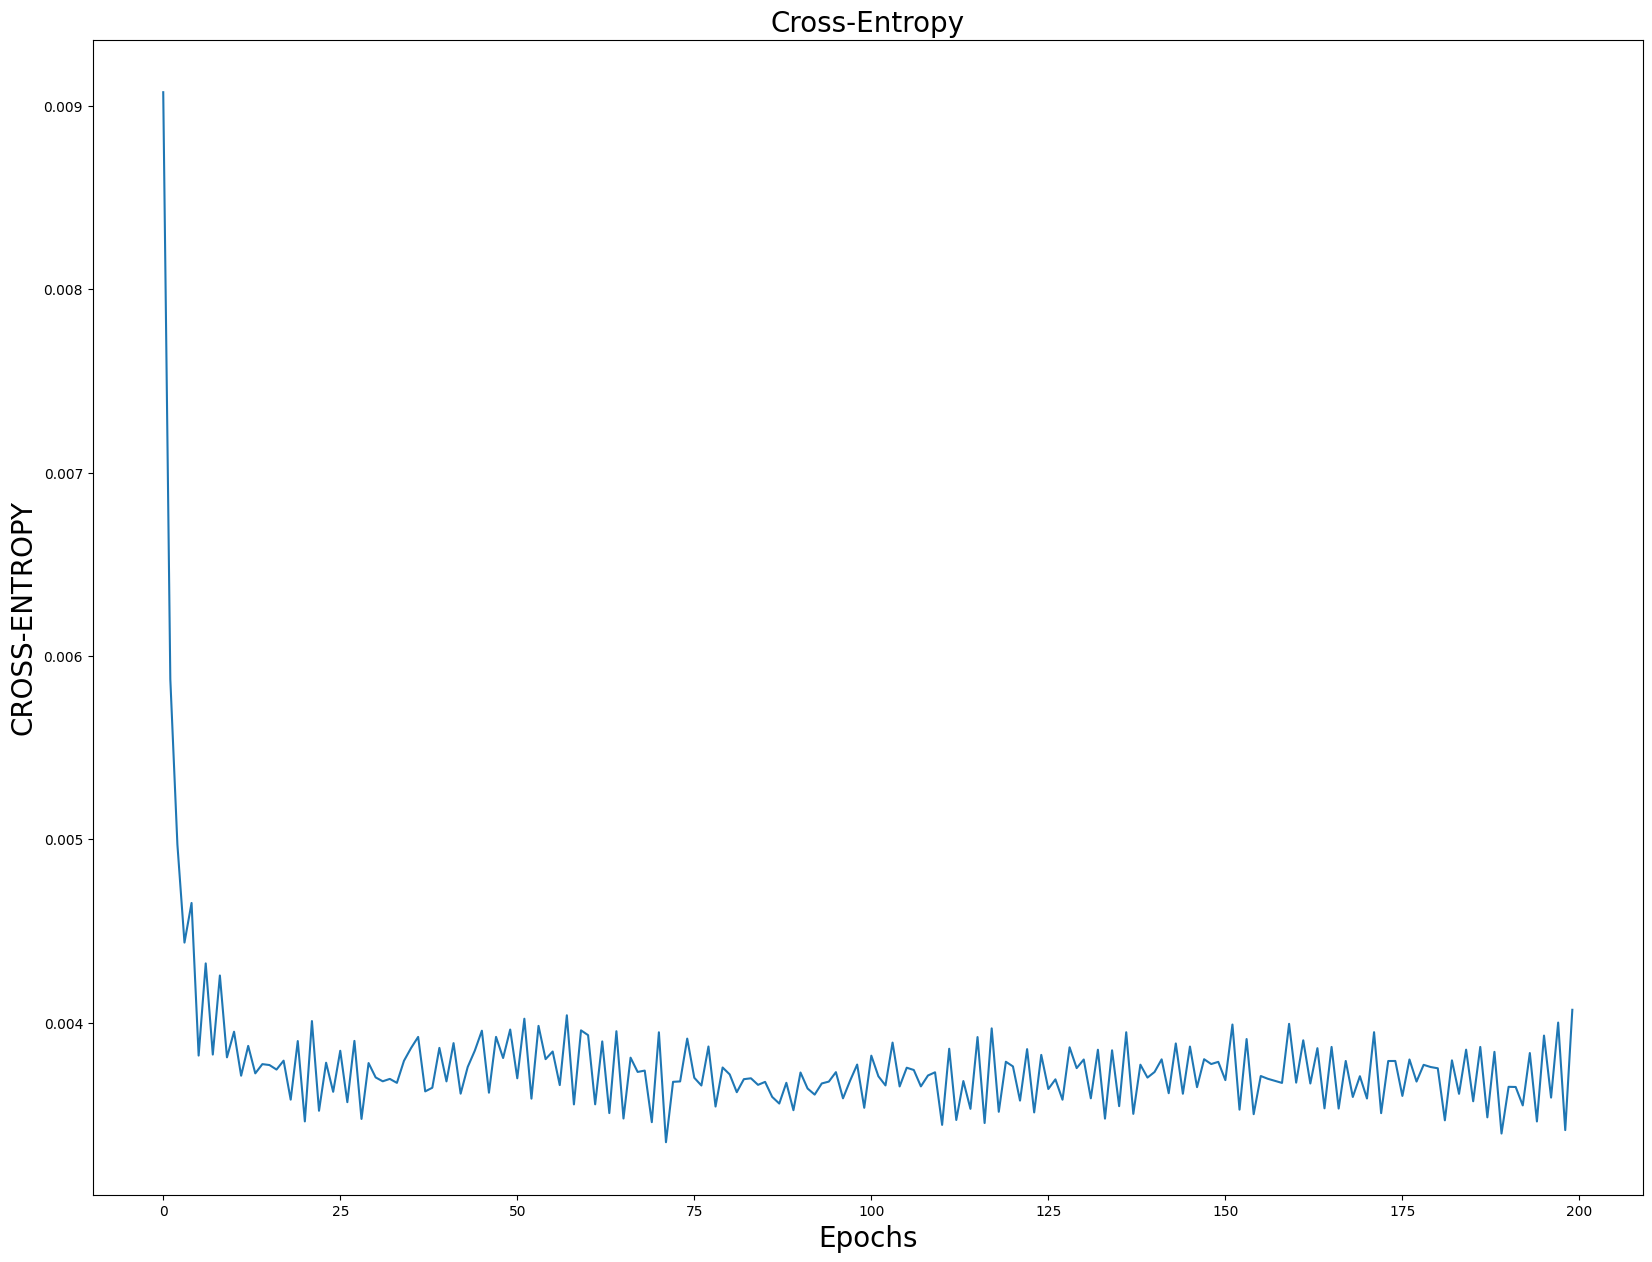

In [39]:
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

CE_array = []
for i in range(epochs):
    Y = Y - lr * CE_gradient(P, Y)
    CE_current = np.sum(CE(P, Y)) / 1e+5
    CE_array.append(CE_current)

    # 保存每 10 轮一次图像帧
    if i % 10 == 0:
        print(f"Cross-Entropy = {CE_current:.4f} after {i} iterations")
        frame_path = os.path.join(output_dir, f"frame_{i:04d}")
        visualize_and_save_frame(smiles, Y, frame_path)

        render_html_to_image(frame_path+'.html', frame_path+'.png')






plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("Epochs", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

In [40]:
visualize_molecule_with_coords(smiles, Y)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [41]:
from vis import make_video_from_frames
make_video_from_frames("frames", "optimization.mp4", fps=5)

In [42]:
from IPython.display import Video
# 直接播放当前目录下的视频
Video("optimization.mp4", embed=True, width=600, height=400)

In [43]:
from dist2coords import coords2dict_mds, coords2dict_tch

## 从pairwise欧式距离还原为坐标

In [44]:
Y = coords2dict_mds(D3)
visualize_molecule_with_coords(smiles, Y)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [45]:
Y = coords2dict_tch(D3)
visualize_molecule_with_coords(smiles, Y)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [46]:
from rdkit import Chem
from rdkit.Chem import Draw

def draw_mol_with_indices(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))  # 设置原子编号为标签

    return Draw.MolToImage(mol, size=(300, 300))


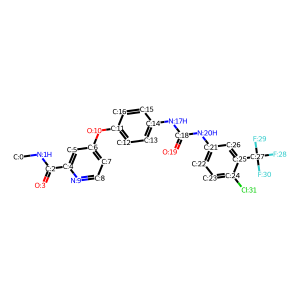

In [47]:
draw_mol_with_indices(smiles)

In [48]:
from moviepy.editor import VideoFileClip
from PIL import Image

# 修复 ANTIALIAS 的兼容性
if not hasattr(Image, 'ANTIALIAS'):
    Image.ANTIALIAS = Image.Resampling.LANCZOS

# 转换视频
clip = VideoFileClip("optimization.mp4").subclip(0, 5)  # 裁剪前5秒
clip = clip.resize(height=300)  # 缩小尺寸
clip.write_gif("optimization.gif", fps=10)  # 保存为GIF


MoviePy - Building file optimization.gif with imageio.
